In [1]:
# !pip install opencv-python scikit-learn pandas numpy matplotlib tensorflow-addons
# !pip install tensorflow==2.12 keras==2.12
# !pip install transformers datasets torchvision

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successfully loaded model weights from path.
Remapped classifier keys to match DeiT teacher architecture.
Weights successfully loaded into DeiT model architecture.
--------------------------------------------------
Processing Category: Benign
--------------------------------------------------

Analyzing image: 1-007.dcm.png
  True Class: 'Benign', Predicted Class: 'Benign'


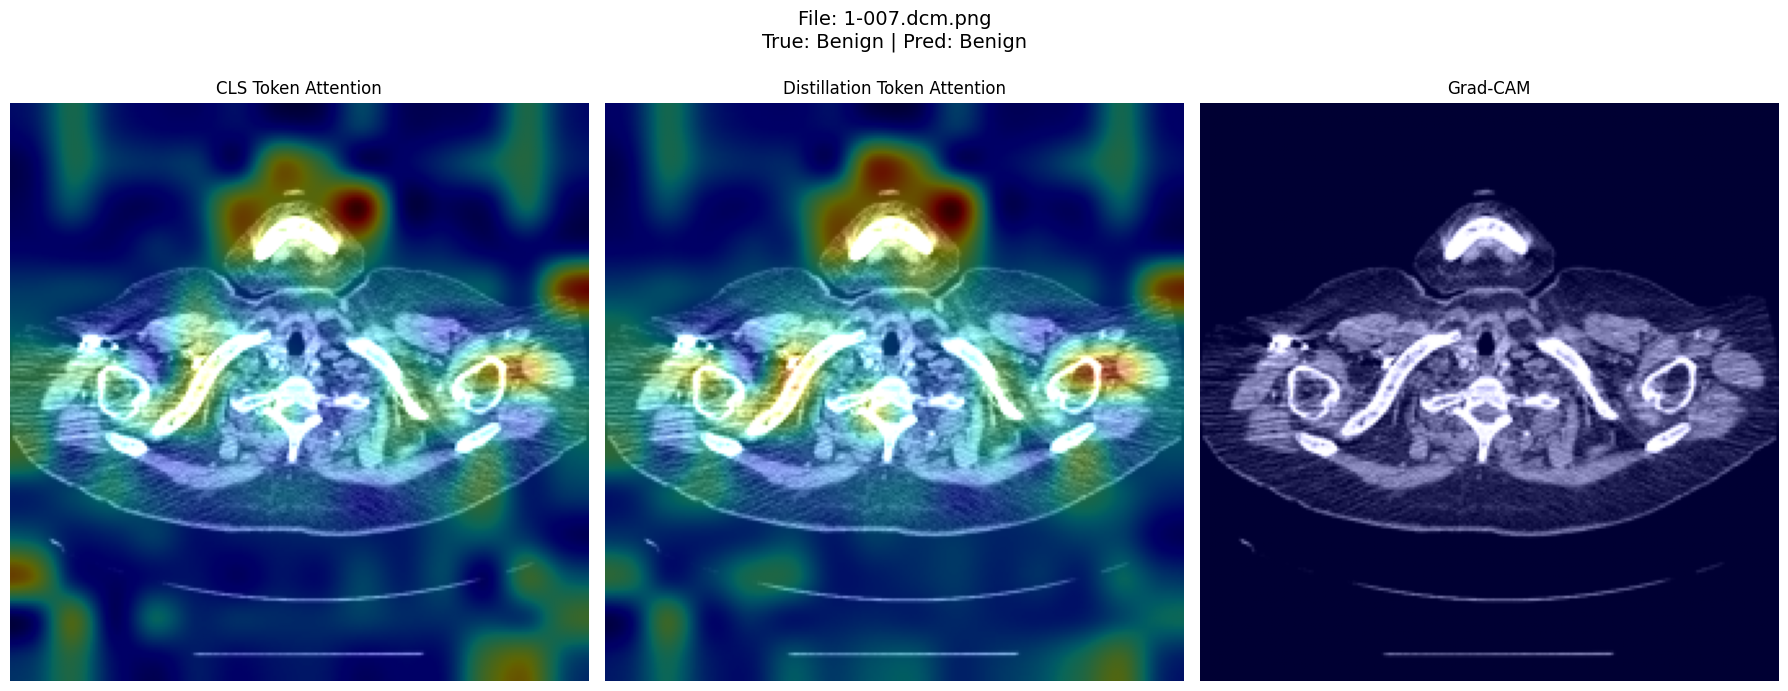


Analyzing image: 1-008.dcm.png
  True Class: 'Benign', Predicted Class: 'Benign'


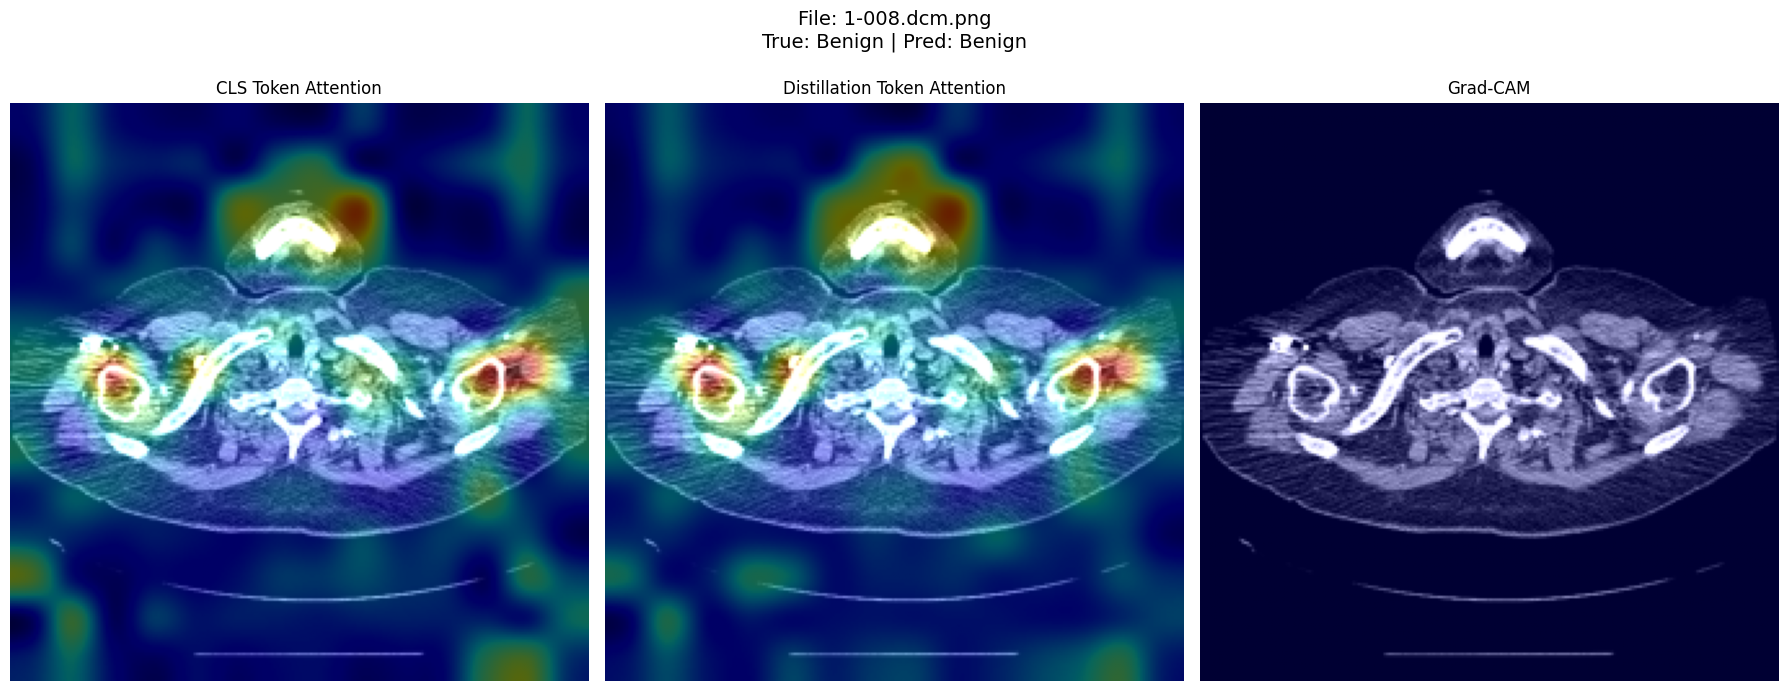


Analyzing image: 1-009.dcm.png
  True Class: 'Benign', Predicted Class: 'Benign'


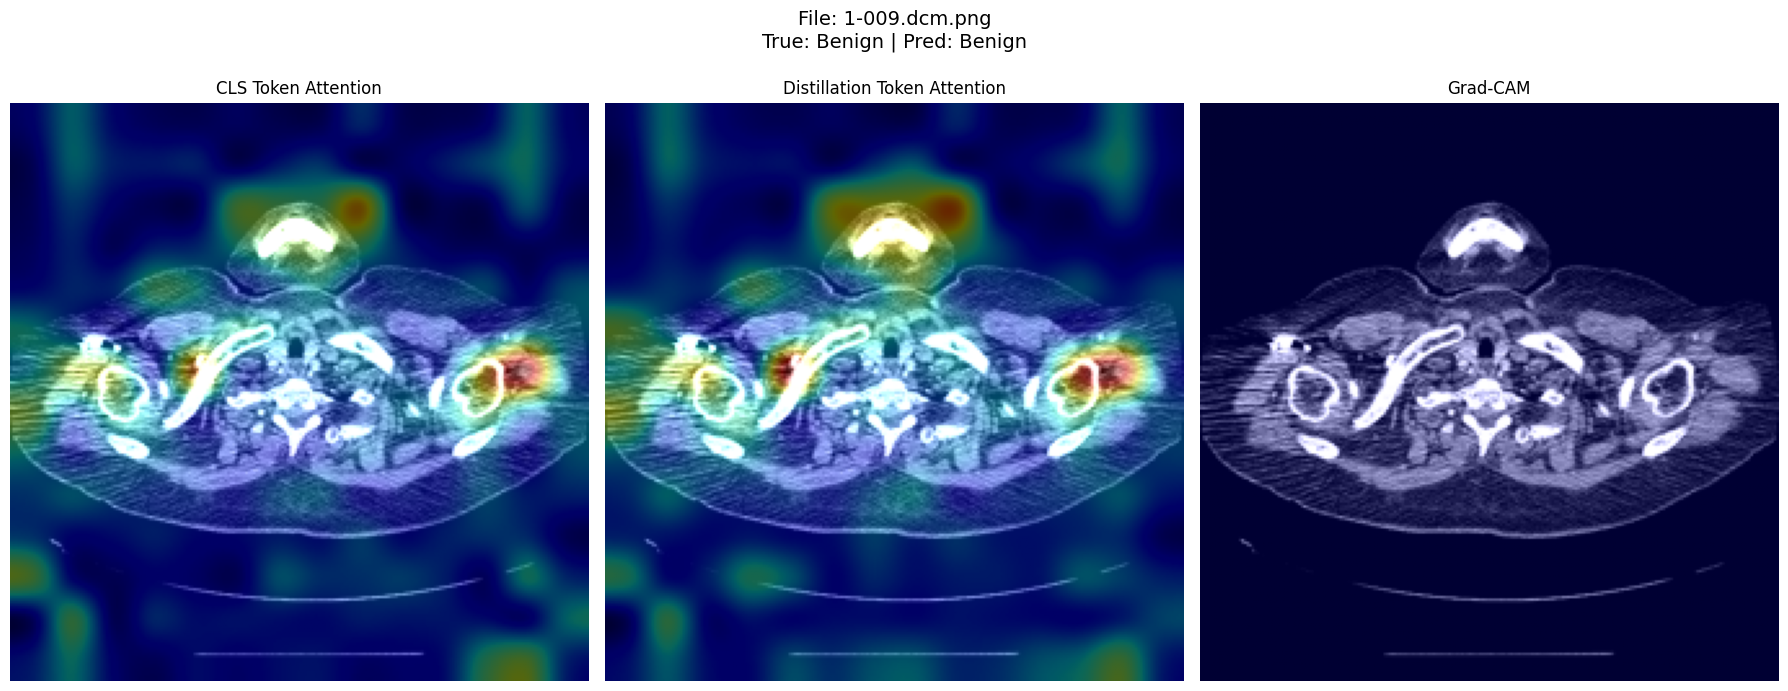

--------------------------------------------------
Processing Category: Malignant
--------------------------------------------------

Analyzing image: 1-007.dcm.png
  True Class: 'Malignant', Predicted Class: 'Malignant'


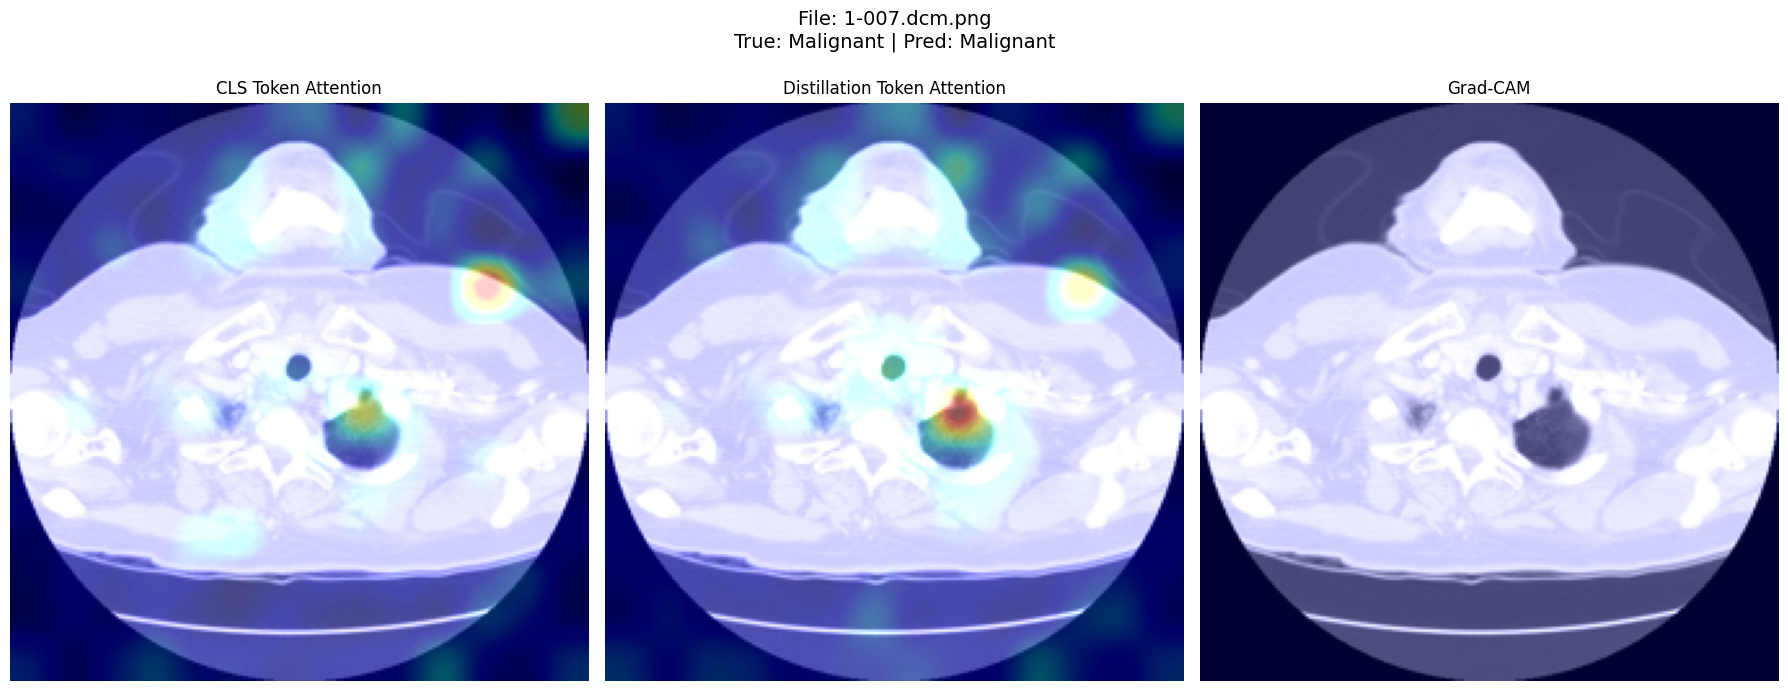


Analyzing image: 1-008.dcm.png
  True Class: 'Malignant', Predicted Class: 'Malignant'


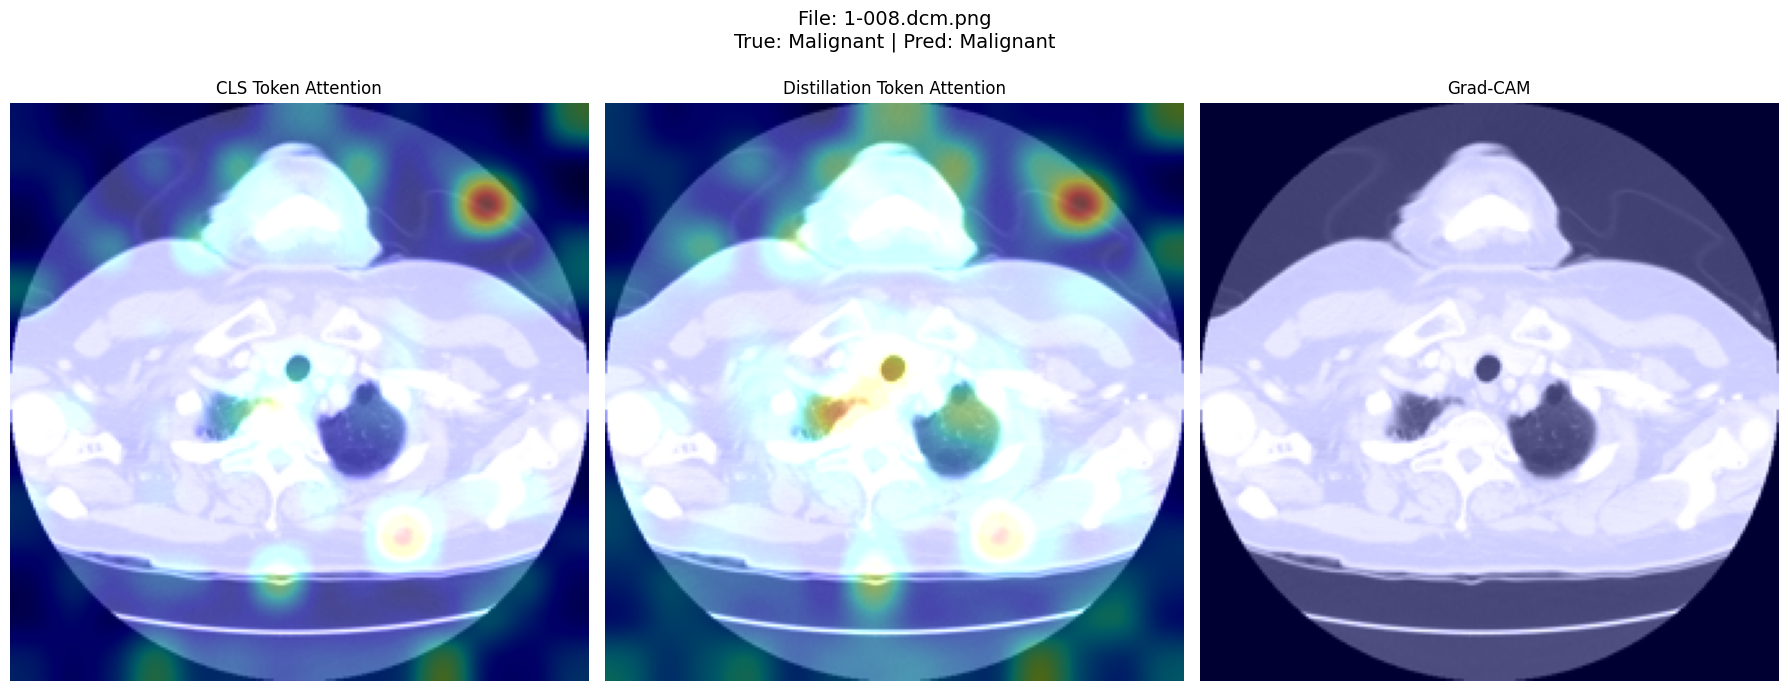


Analyzing image: 1-009.dcm.png
  True Class: 'Malignant', Predicted Class: 'Malignant'


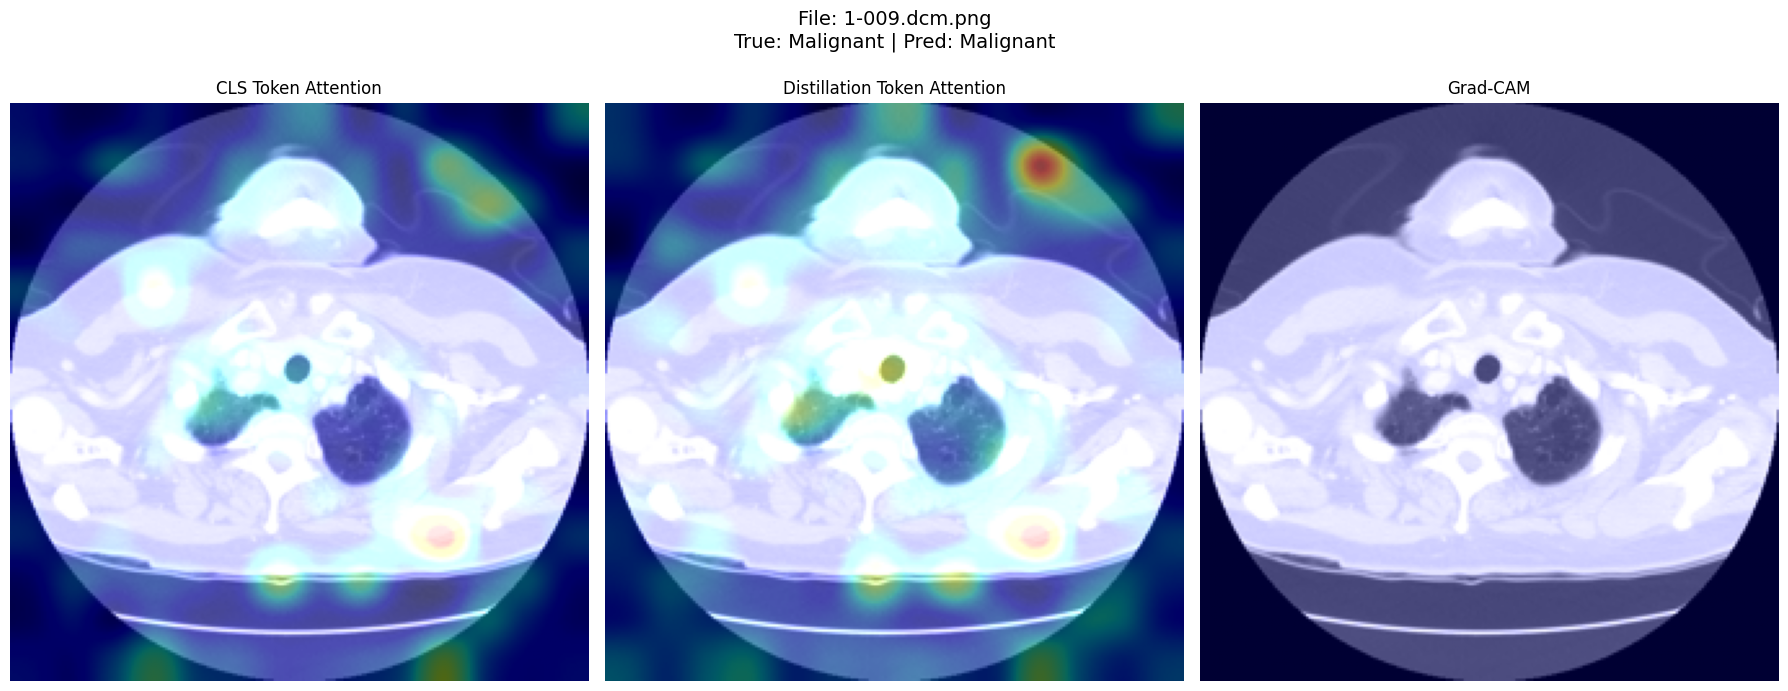

In [15]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
from transformers import DeiTForImageClassificationWithTeacher, DeiTImageProcessor

def show_cam_on_image(img_np, cam_np):
    heatmap = plt.cm.jet(cam_np)[..., :3]
    superimposed_img = heatmap * 0.4 + img_np
    superimposed_img = np.clip(superimposed_img, 0, 1)
    return superimposed_img

class TransformerGradCAM:
    def __init__(self, model, target_block, num_special_tokens=2):
        self.model = model
        self.target_block = target_block
        self.num_special_tokens = num_special_tokens
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _capture_activations(self, module, input, output):
        self.activations = output[0]

    def _capture_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def _register_hooks(self):
        self.h_activations = self.target_block.register_forward_hook(self._capture_activations)
        self.h_gradients = self.target_block.register_full_backward_hook(self._capture_gradients)

    def remove_hooks(self):
        self.h_activations.remove()
        self.h_gradients.remove()

    def __call__(self, input_tensor, target_class):
        self.model.zero_grad()
        output = self.model(**input_tensor)
        logits = output.logits
        logits[:, target_class].backward(retain_graph=True)
        
        activations = self.activations[:, self.num_special_tokens:, :]
        gradients = self.gradients[:, self.num_special_tokens:, :]
        
        alpha = gradients.mean(dim=-1, keepdim=True)
        cam = F.relu((alpha * activations).sum(dim=-1)).view(1, 14, 14)
        
        cam = F.interpolate(cam.unsqueeze(0), (224, 224), mode='bilinear', align_corners=False)
        cam = cam.squeeze().detach().cpu().numpy()
        
        if np.max(cam) == np.min(cam):
            return np.zeros_like(cam)
        
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
        return cam

def generate_and_plot_heatmaps(model, processor, class_mapping, image_path, target_class_name, target_class_index):
    pil_img = Image.open(image_path).convert('RGB')
    display_img_np = np.array(pil_img.resize((224, 224))) / 255.0
    inputs = processor(images=pil_img, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
        
    predicted_class_index = outputs.logits.argmax(-1).item()
    predicted_class_name = class_mapping[predicted_class_index]
    print(f"  True Class: '{target_class_name}', Predicted Class: '{predicted_class_name}'")

    att_mat = outputs.attentions[-1]
    att_mat = torch.mean(att_mat, dim=1)
    
    cls_to_patch_att = att_mat[0, 0, 2:].reshape(14, 14).detach().cpu().numpy()
    cls_att_resized = np.array(Image.fromarray(cls_to_patch_att).resize((224, 224), Image.BICUBIC))
    cls_att_normalized = (cls_att_resized - cls_att_resized.min()) / (cls_att_resized.max() - cls_att_resized.min())
    vis_cls_attention = show_cam_on_image(display_img_np, cls_att_normalized)
    
    distil_to_patch_att = att_mat[0, 1, 2:].reshape(14, 14).detach().cpu().numpy()
    distil_att_resized = np.array(Image.fromarray(distil_to_patch_att).resize((224, 224), Image.BICUBIC))
    distil_att_normalized = (distil_att_resized - distil_att_resized.min()) / (distil_att_resized.max() - distil_att_resized.min())
    vis_distil_attention = show_cam_on_image(display_img_np, distil_att_normalized)

    grad_cam_generator = TransformerGradCAM(model, model.deit.encoder.layer[-1], num_special_tokens=2)
    grad_cam_heatmap = grad_cam_generator(inputs, target_class=target_class_index)
    grad_cam_generator.remove_hooks()
    vis_grad_cam = show_cam_on_image(display_img_np, grad_cam_heatmap)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 7))
    fig.suptitle(f"File: {os.path.basename(image_path)}\nTrue: {target_class_name} | Pred: {predicted_class_name}", fontsize=14)
    
    ax1.imshow(vis_cls_attention)
    ax1.set_title("CLS Token Attention")
    ax1.axis('off')
    ax2.imshow(vis_distil_attention)
    ax2.set_title("Distillation Token Attention")
    ax2.axis('off')
    ax3.imshow(vis_grad_cam)
    ax3.set_title("Grad-CAM")
    ax3.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

if __name__ == '__main__':
    MODEL_NAME = 'facebook/deit-base-distilled-patch16-224'
    model_path = "/kaggle/input/lidc-idri-9565model/best_model_reduce_lr.pth"

    model = DeiTForImageClassificationWithTeacher.from_pretrained(
        MODEL_NAME,
        num_labels=2,
        ignore_mismatched_sizes=True,
        attn_implementation="eager"
    )

    try:
        state_dict = torch.load(model_path, map_location=torch.device('cpu'))
        print("Successfully loaded model weights from path.")
    except FileNotFoundError:
        print(f"ERROR: Model file not found at {model_path}.")
        exit()

    # Fix: remap single classifier head to both cls_classifier & distillation_classifier
    if 'classifier.weight' in state_dict:
        state_dict['cls_classifier.weight'] = state_dict['classifier.weight']
        state_dict['distillation_classifier.weight'] = state_dict['classifier.weight']
        state_dict['cls_classifier.bias'] = state_dict['classifier.bias']
        state_dict['distillation_classifier.bias'] = state_dict['classifier.bias']
        del state_dict['classifier.weight']
        del state_dict['classifier.bias']
        print("Remapped classifier keys to match DeiT teacher architecture.")

    model.load_state_dict(state_dict, strict=False)
    print("Weights successfully loaded into DeiT model architecture.")
    model.eval()

    processor = DeiTImageProcessor.from_pretrained(MODEL_NAME)

    base_path = "/kaggle/input/lung-cancer-detection-lidc-idri-subset/LIDC_IDRI_PNG_CONV/test"
    image_folders = {
        "Benign":    {"path": os.path.join(base_path, "benign"),    "class_index": 0},
        "Malignant": {"path": os.path.join(base_path, "malignant"), "class_index": 1}
    }
    
    class_mapping = {v['class_index']: k for k, v in image_folders.items()}
    IMAGES_PER_CATEGORY = 3

    for class_name, info in image_folders.items():
        folder_path = info["path"]
        class_index = info["class_index"]
        
        print("-" * 50)
        print(f"Processing Category: {class_name}")
        print("-" * 50)
        
        image_files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        files_to_process = image_files[:IMAGES_PER_CATEGORY]

        for filename in files_to_process:
            print(f"\nAnalyzing image: {filename}")
            image_path = os.path.join(folder_path, filename)
            generate_and_plot_heatmaps(model, processor, class_mapping, image_path, class_name, class_index)


In [14]:
print(model)

DeiTForImageClassificationWithTeacher(
  (deit): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)